## Context

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store. Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales. Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

## Objective

To build a predictive model and find out the sales of each product at a particular store. And then provide recommendations to the BigMart sales team to understand the properties of products and stores which play a key role in increasing sales.

## Data Dictionary

- **Item_Identifier** : Unique product ID

- **Item_Weight** : Weight of product

- **Item_Fat_Content** : Whether the product is low fat or not

- **Item_Visibility** : The % of the total display area of all products in a store allocated to the particular product

- **Item_Type** : The category to which the product belongs

- **Item_MRP** : Maximum Retail Price (list price) of the product

- **Outlet_Identifier** : Unique store ID

- **Outlet_Establishment_Year** : The year in which the store was established

- **Outlet_Size** : The size of the store in terms of ground area covered

- **Outlet_Location_Type** : The type of city in which the store is located

- **Outlet_Type** : Whether the outlet is just a grocery store or some sort of supermarket

- **Item_Outlet_Sales** : Sales of the product in the particular store. This is the outcome variable to be predicted.

We have two datasets - train (8523) and test (5681) data. The train dataset has both input and output variable(s). You need to predict the sales for the test dataset.

## Loading libraries and overview of datasets

In [113]:
# Library to suppress warnings
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Center a matplotlib figure in a Jupyter notebook
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [114]:
# importing libraries for data manipulation
import numpy as np
import pandas as pd

# importing libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# importing libraries for building linear regression model
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# importing libraries for scaling the data
from sklearn.preprocessing import MinMaxScaler

In [115]:
sns.set(font_scale=1.025, rc={'figure.figsize': (10, 6),
                              'axes.facecolor': '#f2f2f0',
                              'axes.edgecolor': '#f2f2f0',
                              'figure.facecolor': '#f2f2f0', 
                              'grid.color': '#c4c4c4', 
                              'grid.linewidth': 0.5,
                              'lines.linewidth': 1.5,
                              'text.color': '#000000',
                              'xtick.color': '#000000',
                              'ytick.color': '#000000'})

#### Utility Functions 

In [116]:
def triag_corr(df: pd.DataFrame, fig_xy: list = [13,10], cmap: str = 'rocket', annot: bool = True, annot_s: int = 8, 
               fmt: str = ".3%", abs_: bool = False, method: str = 'pearson') -> plt.figure:
    plt.figure(figsize=(fig_xy[0], fig_xy[1]))
    corr = df.corr(method=method).abs() if abs_ else df.corr(method=method)
    mask = np.tri(*corr.shape).T 
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=annot, annot_kws={"size":annot_s}, fmt=fmt)
    plt.show()
    
def get_redundant_pairs(df: pd.DataFrame) -> set:
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def mu_std_corr_matrix(corr: pd.DataFrame or np.array, rnd: int = 3):
    corr = corr.abs().copy()
    corr.values[np.tril_indices_from(corr)] = np.nan     
    return (round(corr.unstack().mean(),rnd), round(corr.unstack().std(),rnd))

def get_top_abs_correlations(df: pd.DataFrame, n: int = 5) -> pd.Series:
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)\
                     .to_frame().rename(columns={0:'Correlation'}).rename_axis(['X', 'y'])
    return au_corr[0:n]

def bin_count(data):
    bins = np.sqrt(len(data))
    return int(bins)

#### Loading datasets

In [117]:
# loading both train and test datasets
train_df = pd.read_csv('Train.csv')
test_df = pd.read_csv('Test.csv')

In [118]:
# checking the dataset
train_df.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

#### Observations:

- As the variables `Item_Identifier` and `Outlet_Identifier` are only ID variables, we assume that they don't have any predictive power to predict the dependent variable / outcome variable - `Item_Outlet_Sales`.
- We remove these two variables from both the datasets.

In [121]:
train_df = train_df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)
test_df = test_df.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)

Now, let's find out some more information about the dataset i.e. total number of observations in the dataset, columns and their data types, etc.

In [122]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


#### Observations:

- The train datasets has `8523` number of observations and `10` columns. 
- Two columns- `Item_Weight` and `Outlet_Size` has missing values as their non-null values is less the total number of observations in the dataset. 
- We can also see that the columns - `Item_Fat_Content`, `Item_Type`, `Outlet_Size`, `Outlet_Location_Type` and `Outlet_Type` has data type `object` that means they are strings which means they are categorical variables. 
- Remaining all other variables have data type `float64` that means they are numerical in nature.

As we have already seen that two columns have missing values in the dataset. Let's check the percentage of missing values using the below piece of code.

In [123]:
train_df.isnull().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [9]:
(train_df.isnull().sum()/train_df.shape[0])*100

Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

Now we get the percentage of missing values for the columns - `Item_Weight` and `Outlet_Size` which are ~17% and ~28% respectively. We will see next how to treat these missing values.

## EDA and Data Preprocessing

Now that we have an understanding of the business problem which we want to solve and also we have loaded the datasets. The next step to follow is to have a better understanding of the dataset i.e. what is the distribution of the variables, what are different relationships that exist between variables, etc. If there is any data anomaly like missing values, outliers, how do we treat them to prepare the dataset for building the predictive model.

### Univariate Analysis

Let us now start exploring the dataset, by performing univariate analysis of the dataset i.e. analyzing/visualizing the dataset by taking one variable at a time. Data visualization is a very important skill to have and we need to decide what charts to plot to better understand the data. For example - what chart makes sense to analyze categorical variable or what charts are suited for numerical variable and also it also depends on what relationship between variables we want to show?

Let's start with analyzing the `categorical` variables present in the data. There are five categorical variables in this dataset and we are creating univariate bar charts for each of them to check their distribution. 

Below we are creating 4 subplots to plot them in a single frame

In [10]:
def cat_count_plot(data: pd.DataFrame, cat_cols: list, title: str, n_cols: int = 2, figsize: list = [16, 26]) -> None:
    fig, axs = plt.subplots(ncols=n_cols, nrows=1, figsize=(figsize[0], figsize[1]))
    for i, feature in enumerate(cat_cols, 1):    
        plt.subplot(len(cat_cols), n_cols, i)
        sns.countplot(
            x=feature, 
            data=data,
            order=data[f'{feature}'].value_counts()\
                                    .sort_values(ascending=False).index)
        plt.title(f'{feature}', size=14, fontsize=14)
        plt.xticks(rotation=90)
        plt.xlabel('')
    fig.suptitle(f'{title}', fontsize=18)
    plt.tight_layout()
    fig.subplots_adjust(top=0.945)
    plt.show()

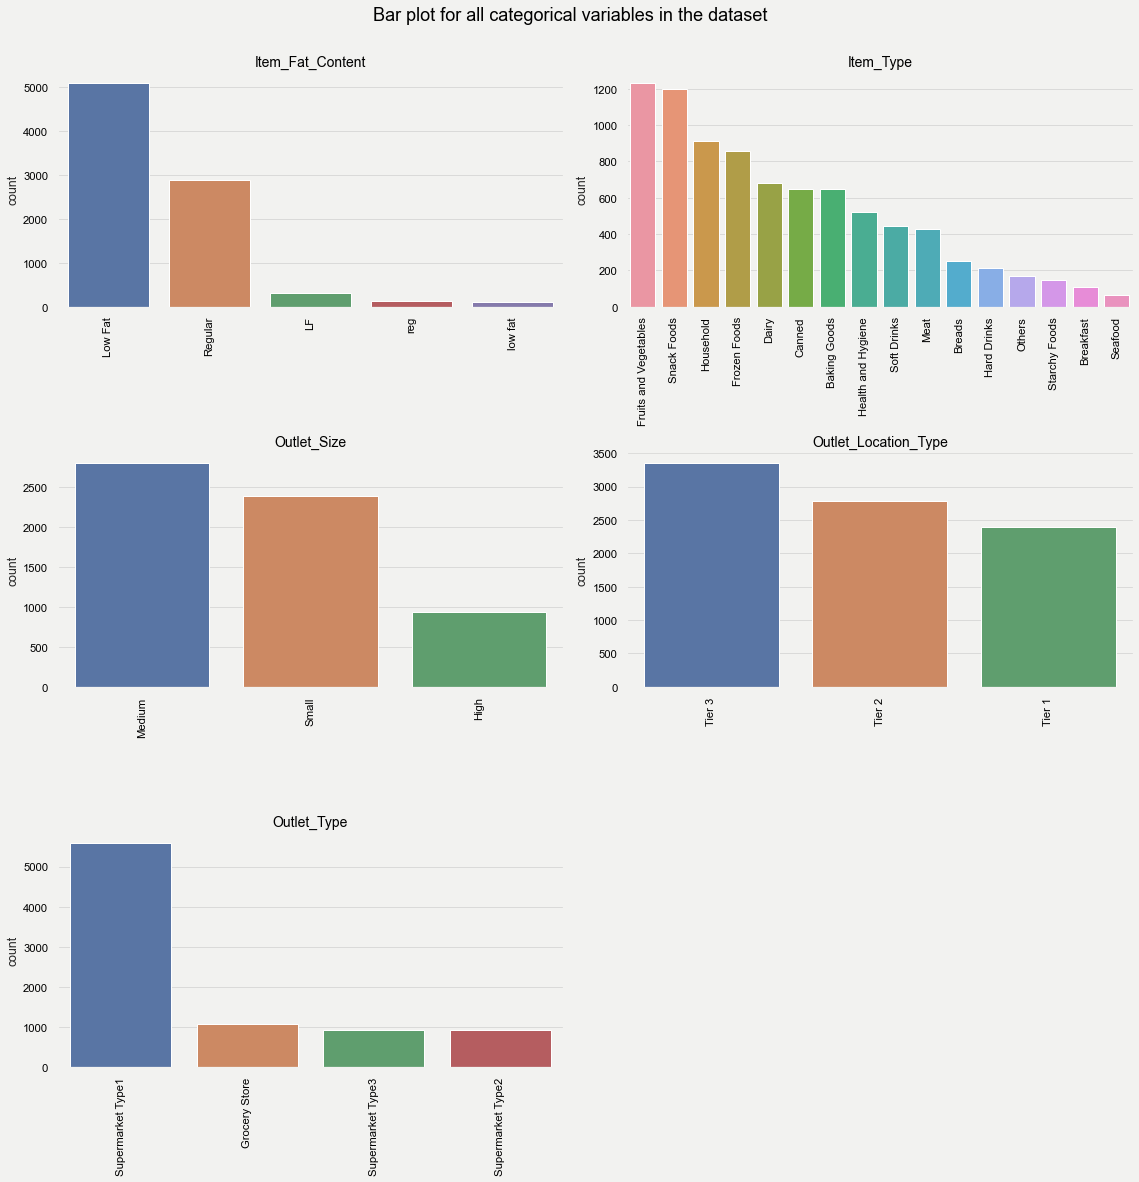

In [11]:
cat_count_plot(
    data=train_df,
    cat_cols=train_df.select_dtypes(include=np.object).columns,
    title='Bar plot for all categorical variables in the dataset',
    n_cols=2,
    figsize=[16, 26]
)

#### Observations:

- From the above univariate plot for the variable `Item_Fat_Content`, it seems like there are errors in the data. The category - `Low Fat` is sometimes also written as `low fat` and `LF`. And also the category `Regular` is also written as `reg` sometimes. So **we need to fix this issue in the data**.
- For the column `Outlet_Size`, we can see that the most common category is - `Medium` followed by Small and High
- The most common category for the column `Outlet_Location_Type` is `Tier 3`, followed by Tier 2 and Tier 1. This makes sense now if we combine this information with the information on column `Outlet_Size`. We would expect High outlet size stores to be present in Tier 1 cities and the count of tier 1 cities is less so the count of high outlets size is also less. And we would expect more number of medium and small number of outlet sizes in the dataset because we have more number outlets present in tier 3 and tier 2 cities in the dataset.
- In the column `Outlet_Type`, the majority of the stores or the model is of `Supermarket Type 1` and we have less and almost equal number of representation in the other categories - Supermarket Type 2 and Supermarket Type 3 and Grocery Store.

Below we are analyzing the categorical variable `Item_Type`

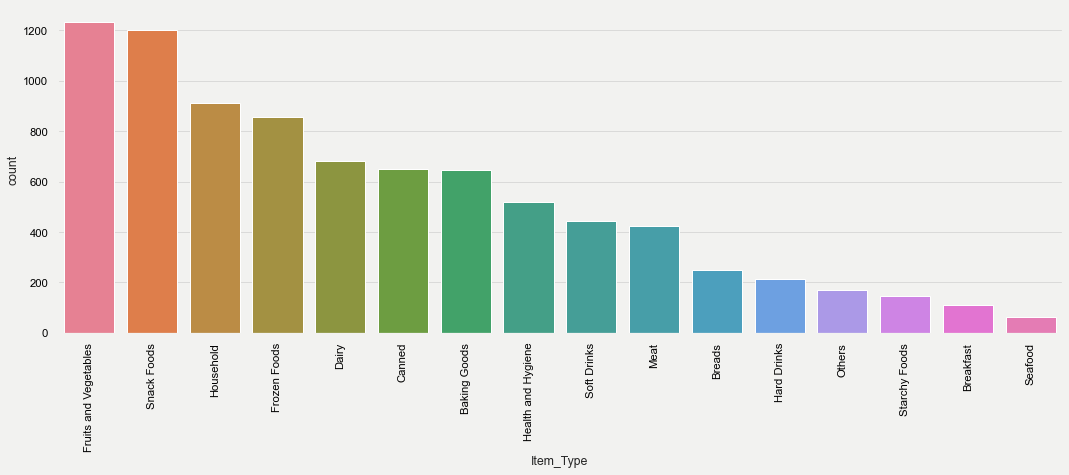

In [12]:
fig= plt.figure(figsize=(18, 6))
sns.countplot(x='Item_Type', data=train_df, palette='husl', order=train_df['Item_Type'].value_counts().index);
plt.xticks(rotation=90);

From the above plot, we can see that majority of the the items sold in these stores are `Fruits and Vegetables`, followed by `Snack Foods`, `Household items`

Before we move ahead with the univariate analysis for the numerical variables, let's first fix the data issues that we have found out for the column `Item_Fat_Content`

In the below piece of code, we are replacing the categories - `low fat` and `LF` by `Low Fat` using lambda function and also we are replacing the category `reg` by Regular.

In [13]:
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x=='low fat' or x=='LF' else x)
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].apply(lambda x: 'Regular' if x=='reg' else x)

The data preparation steps that we do on the training data, we need to perform the same steps on test data as well. So below we are performing the same transformation on `test` dataset - 

In [14]:
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: 'Low Fat' if x=='low fat' or x=='LF' else x)
test_df['Item_Fat_Content'] = test_df['Item_Fat_Content'].apply(lambda x: 'Regular' if x=='reg' else x)

Below we are analyzing all the `numerical` variables present in the data. And since we want to visualize one numerical variable at a time, histogram is the best choice to visualize the data

In [127]:
def num_dist_plot(data: pd.DataFrame, num_cols: list, title: str, n_cols: int = 2, figsize: list = [16, 26]) -> None:
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(figsize[0], figsize[1]))
    for i, feature in enumerate(num_cols, 1):    
        plt.subplot(len(num_cols), n_cols, i)
        sns.histplot(
            x=feature, 
            data=data,
            kde=True)
    fig.suptitle(f'{title}', fontsize=18)
    plt.tight_layout()
    fig.subplots_adjust(top=0.945)
    plt.show()

In [16]:
train_df.select_dtypes(include=np.number).columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [17]:
num_dist_plot(
    data=train_df,
    num_cols=['Item_Weight', 'Item_Visibility', 'Item_MRP'],
    title='Histogram for all numerical variables in the dataset',
    n_cols=3,
    figsize=[16, 15]
)

#### Observations -

- The variable `Item_Weight` is approx uniformally distributed and when we will impute the missing values for this column we will need to keep this in mind that we don't end up changing the distribution significantly after imputing those missing values
- The variable `Item_Visibility` is a right skewed distribution which means that there are certain items whose percentage of display area is much higher than the other items
- The variable `Item_MRP` is following approx multi-modal normal distribution

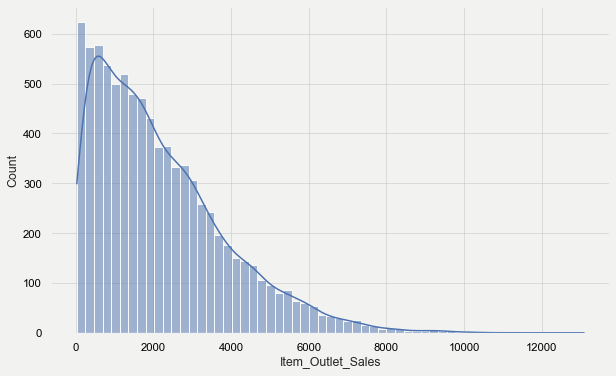

In [18]:
sns.histplot(train_df['Item_Outlet_Sales'], kde=True);

### Bivariate Analysis

Now let's move ahead with bivariate analysis and to understand how variables are related to each other and if there is a strong relationship between dependent and independent variables present in the training dataset. 

In the below plot - we are analyzing the variables `Outlet_Establishment_Year` and `Item_Outlet_Sales`. Here, since the variable `Outlet_Establishment_Year` is defining a time component, the best chart to analyze this relationship will be a line plot.

In [19]:
fig= plt.figure(figsize=(18, 6))
sns.lineplot(
    x='Outlet_Establishment_Year', 
    y='Item_Outlet_Sales', 
    data=train_df, 
    ci=None, 
    estimator='mean'
);

#### Observations:

- The average sales are almost constant every year, but we don't see any increasing/decreasing trend in sales with time. So the variable year might not be a good predictor to predict sales, which we can see later in the modeling phase.
- Also, in the year 1998 the average sales has plummeted. This might be due to some external factors which are not included in the data.

Next, we are trying to find out linear correlations between the variables, This will help us to know which numerical variables are correlated with the dependent/target variable. Also we can find out multi-collinearity i.e. which pair of independent variables are correlated with each other.

In [20]:
triag_corr(
    df=train_df, 
    fig_xy=[18,10],
    abs_=False,
    cmap='viridis',
    method='pearson',
    fmt='.2%',
    annot_s=12
)

#### Observations:

- From the above plot, it seems only the independent variable `Item_MRP` has moderate linear relationship with the dependent variable `Item_Outlet_Sales`
- For the remaining, it does not seem like there is any strong positive/negative correlation between the variables

In [21]:
mu_abs_corr, std_abs_corr = mu_std_corr_matrix(corr=train_df.corr(), rnd=3)
top_abs_corrs = get_top_abs_correlations(
    train_df.select_dtypes(include=np.number), 
    20
)
top_abs_corrs.head()

Correlation
X                         y                                     
Item_MRP                  Item_Outlet_Sales             0.567574
Item_Visibility           Item_Outlet_Sales             0.128625
                          Outlet_Establishment_Year     0.074834
Outlet_Establishment_Year Item_Outlet_Sales             0.049135
Item_Weight               Item_MRP                      0.027141

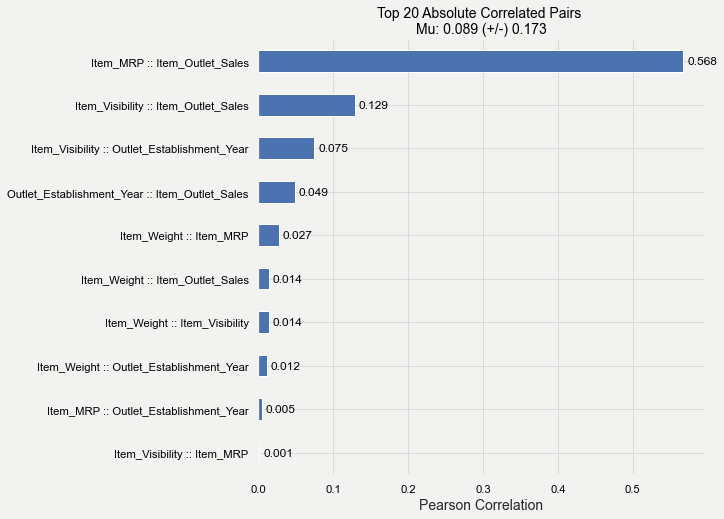

In [22]:
abs_corrs_idx = [str(i)+' :: '+str(x) for i, x in zip(top_abs_corrs.index.droplevel(1), top_abs_corrs.index.droplevel(0))]
top_abs_corrs = pd.DataFrame(top_abs_corrs.values, index=abs_corrs_idx, columns=['Correlation'])

fig, ax = plt.subplots(figsize=(8,8))
top_abs_corrs.sort_values('Correlation').plot(kind='barh', ax=ax, legend=False)
for i, v in enumerate(top_abs_corrs.sort_values('Correlation').values):
    ax.text(x=v + 0.045, y=i, s=str(round(v[0],3)), fontweight='medium', fontsize=12, 
        va='center', ha='right')
plt.title(f'Top 20 Absolute Correlated Pairs \nMu: {mu_abs_corr} (+/-) {std_abs_corr}', fontsize=14)
plt.xlabel('Pearson Correlation', fontsize=14);

Next, we are creating the bivariate scatter plots to check relationships between pairs of independent and dependent variables 

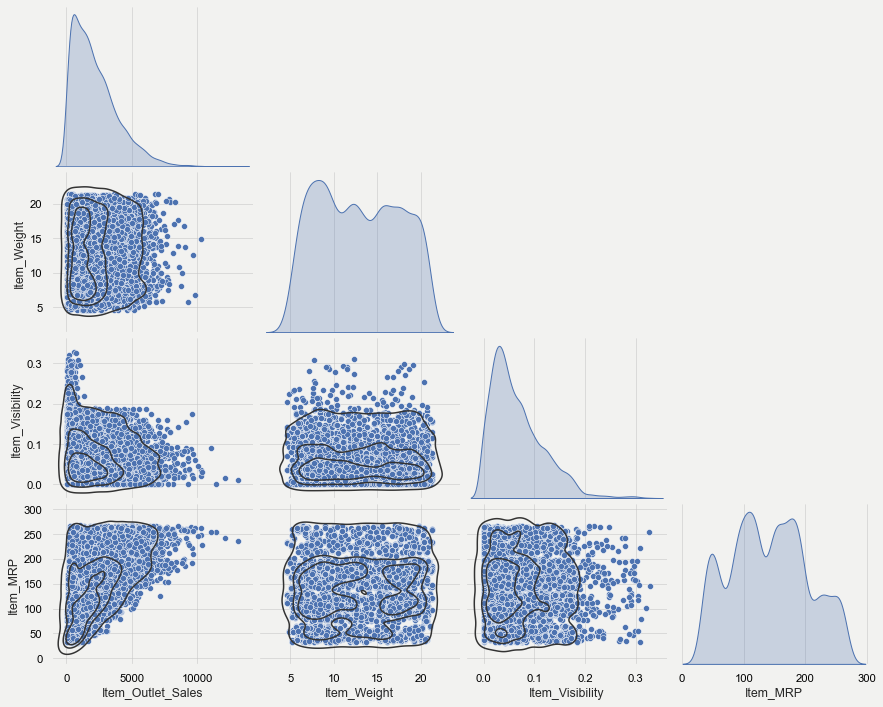

In [23]:
num_cols = ['Item_Outlet_Sales', 'Item_Weight', 'Item_Visibility', 'Item_MRP']

g = sns.pairplot(
    data=train_df,
    vars=num_cols,
    diag_kind='kde',
    # hue='Outlet_Location_Type',
    corner=True, 
    height=2.5, 
    aspect=1.25
)

g.map_lower(
    sns.kdeplot, 
    levels=4, 
    color=".2"
);

#### Observations:

- The first scatter plot shows the data is completely random and there is no relationship between `Item_Weight` and `Item_outlet_Sales`. This is also evident from the correlation number which we got above i.e. there is no strong correlation between these two variables
- The second scatter plot between `Item_Visibility` and `Item_outlet_Sales`, there is no good relationship between them. But we can see a pattern that, as the `Item_Visibility` increases from **0.19**, the sales decreases. This might be due the reason that the management has given more visibility to those items which are not generally sold often, thinking that better visibility would increase the sales. This information can also help us to engineer new feature like - a categorical variable with categories - `high visibility` and `low visibility`. But we are not doing this here. This is an idea, we may want to pursue in future.
- The third scatter plot between the variables - `Item_MRP` and `Item_outlet_Sales`, it is clear that there is a positive correlation between them and the variable `Item_MRP` would have a good predictive power to predict the sales.

In [24]:
pd.DataFrame(
    np.where(train_df['Item_Visibility'] >= 0.19, 1, 0), index=train_df.index
)

0
0     0
1     0
2     0
3     0
4     0
...  ..
8518  0
8519  0
8520  0
8521  0
8522  0

[8523 rows x 1 columns]

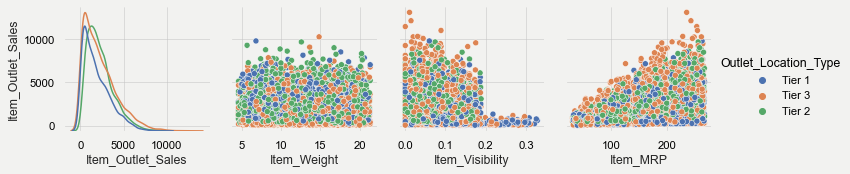

In [25]:
g = sns.PairGrid(
    train_df, 
    hue="Outlet_Location_Type", 
    x_vars=num_cols, 
    y_vars='Item_Outlet_Sales'
)
g.map_diag(sns.kdeplot, color=".3")
g.map_offdiag(sns.scatterplot)
g.add_legend();

### Missing value treatment

Here we are imputing missing values for the variable `Item_Weight`. There are many ways to impute missing values, we can impute the missing values by its `mean`, `median` and using advanced imputation algorithm like `knn` etc. But here we are trying to find out some relationship of the variable `Item_Weight` with other variables in the dataset to impute those missing values

And also after imputing the missing values for the variables, the overall distribution of the variable should not change significantly

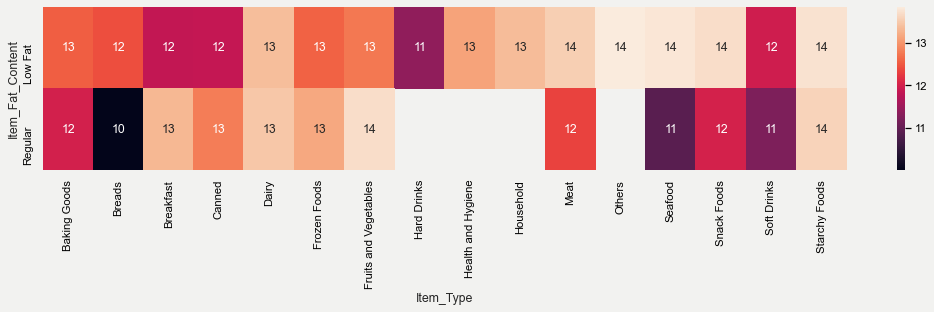

In [26]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(train_df.pivot_table(index='Item_Fat_Content', columns='Item_Type', values='Item_Weight'), annot=True);
plt.xticks(rotation=90);

#### Observations:

- In the above heatmap, we can see that based on different combination of `Item_Types` and `Item_Fat_Content`, the average range of values for the column `Item_Weight` lies between the minimum value 10 and maximum value of 14

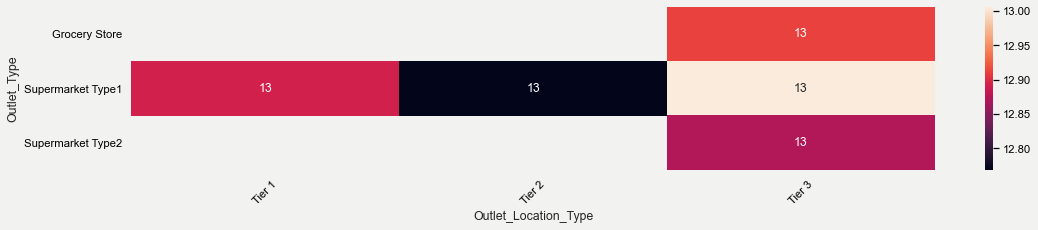

In [27]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(train_df.pivot_table(index='Outlet_Type', columns='Outlet_Location_Type', values='Item_Weight'), annot=True);
plt.xticks(rotation=45);

#### Observations:

- In the above heatmap, we can see that based on different combination of `Outlet_Type` and `Outlet_Location_Type`, the average range of values for the column `Item_Weight` is constant at 13

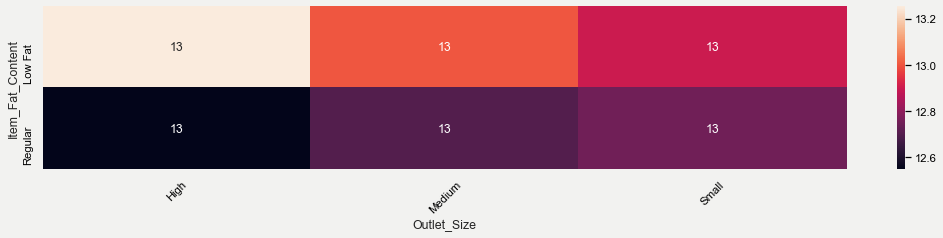

In [28]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(train_df.pivot_table(index='Item_Fat_Content', columns='Outlet_Size', values='Item_Weight'), annot=True);
plt.xticks(rotation=45);

#### Observations:

- In the above heatmap, we can see that based on different combination of `Item_Fat_Content` and `Outlet_Size`, the average range of values for the column `Item_Weight` is also constant at 13

We will impute the missing values using an uniform distribution with parameters a=10 and b=14, as shown below - 

In [29]:
item_weight_indices_to_be_updated = train_df[train_df['Item_Weight'].isnull()].index

train_df.loc[item_weight_indices_to_be_updated, 'Item_Weight'] = np.random.uniform(
                                                                            10, 
                                                                            14, 
                                                                            len(item_weight_indices_to_be_updated))

Performing the same transformation on `test` dataset

In [30]:
item_weight_indices_to_be_updated = test_df[test_df['Item_Weight'].isnull()].index
test_df.loc[item_weight_indices_to_be_updated, 'Item_Weight'] = np.random.uniform(
                                                                           10, 
                                                                           14, 
                                                                           len(item_weight_indices_to_be_updated))

Next we will be imputing missing values for the column `Outlet_Size`. Below are creating two different datasets - one where we have non-null values for the column `Outlet_Size` and in the other dataset we all the values of the column `Outlet_Size` are missing. We then check the distribution of the other variables in the dataset where `Outlet_Size` is missing to identify if there is any pattern present or not

In [31]:
outlet_size_data = train_df[train_df['Outlet_Size'].notnull()]
outlet_size_missing_data = train_df[train_df['Outlet_Size'].isnull()]

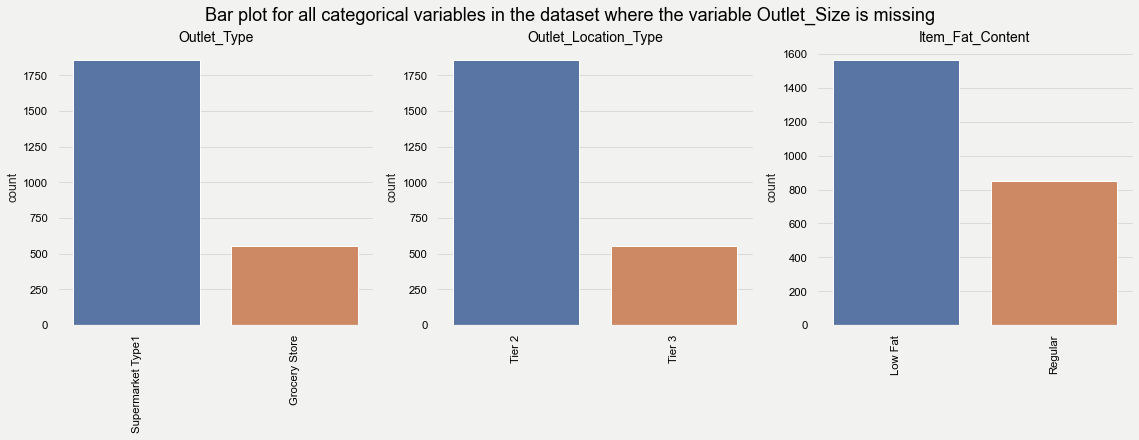

In [32]:
cat_count_plot(
    data=outlet_size_missing_data,
    cat_cols=['Outlet_Type', 'Outlet_Location_Type', 'Item_Fat_Content'],
    title='Bar plot for all categorical variables in the dataset where the variable Outlet_Size is missing',
    n_cols=3,
    figsize=[16, 16]
)

#### Observations:

- We can see that, in the dataset, wherever `Outlet_Size` is missing majority of them have `Outlet_Type` as Supermarket Type 1 and `Outlet_Loaction_Type` as Tier 2 and `Item_Fat_Content` as `Low Fat`

Now are creating a crosstab of all the above categorical variables against the column `Outlet_Size` where we want to impute the missing values

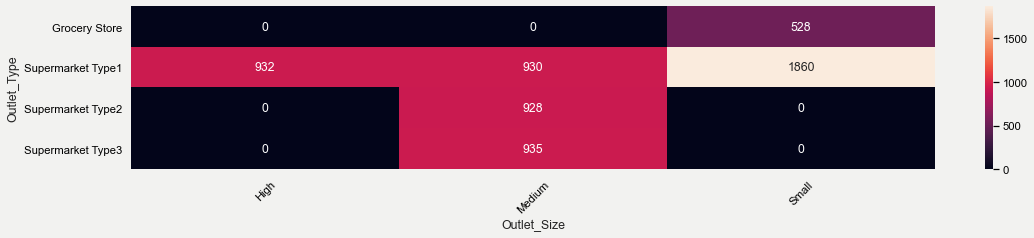

In [33]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(pd.crosstab(index=outlet_size_data['Outlet_Type'], columns=outlet_size_data['Outlet_Size']), annot=True, fmt='g')
plt.xticks(rotation=45);

#### Observations - 

- We can see from the crosstab, all the grocery stores have `Outlet_Size` as small
- And all the Supermarket Type 2 and Supermarket Type 3 have `Outlet_Size` as Medium

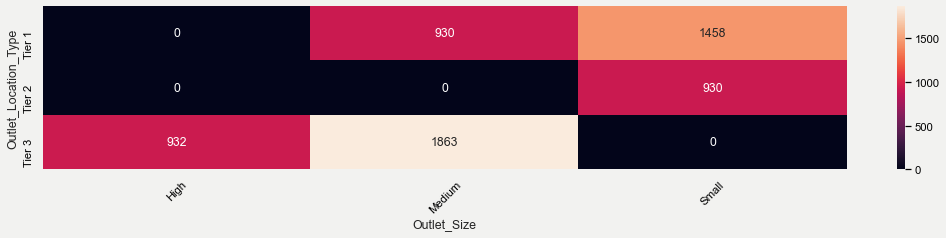

In [34]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(pd.crosstab(index=outlet_size_data['Outlet_Location_Type'], columns=outlet_size_data['Outlet_Size']), annot=True, 
            fmt='g')
plt.xticks(rotation=45);

#### Observations:

- We can see from the crosstab, all the Tier 2 stores have `Outlet_Size` as Small

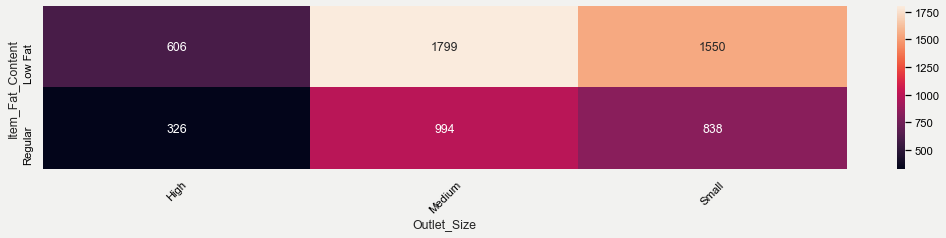

In [35]:
fig= plt.figure(figsize=(18, 3))
sns.heatmap(pd.crosstab(index=outlet_size_data['Item_Fat_Content'], columns=outlet_size_data['Outlet_Size']), annot=True, 
            fmt='g')
plt.xticks(rotation=45);

#### Observations:

- There is no clear pattern betweent the variables `Item_Fat_Content` and `Outlet_Size` unlike what we have got against `Outlet_Type` and `Outlet_Location_Type`

Now we will use the patterns we have from the variables `Outlet_Type` and `Outlet_Location_Type` to impute the missing values for the column `Outlet_Size`

Below we are identifying the indices in the dataframe where `Outlet_Size` is null/missing and `Outlet_Type` is Grocery Store, so that we can replace those missing values with the value Small based on the pattern we have identified in above crosstab visualization. Similarly we are also identifying the indices in the dataframe where `Outlet_Size` is null/missing and `Outlet_Location_Type` is Tier 2, to impute those missing values.

In [36]:
grocery_store_indices = train_df[train_df['Outlet_Size'].isnull()].query("Outlet_Type == 'Grocery Store'").index
tier_2_indices = train_df[train_df['Outlet_Size'].isnull()].query("Outlet_Location_Type == 'Tier 2'").index

Now are updating those indices for the column `Outlet_Size` with the value Small

In [37]:
train_df.loc[grocery_store_indices, 'Outlet_Size'] = 'Small'
train_df.loc[tier_2_indices, 'Outlet_Size'] = 'Small'

Performing the same transformation on `test` dataset

In [38]:
grocery_store_indices = test_df[test_df['Outlet_Size'].isnull()].query("Outlet_Type == 'Grocery Store'").index
tier_2_indices = test_df[test_df['Outlet_Size'].isnull()].query("Outlet_Location_Type == 'Tier 2'").index

In [39]:
test_df.loc[grocery_store_indices, 'Outlet_Size'] = 'Small'
test_df.loc[tier_2_indices, 'Outlet_Size'] = 'Small'

After we have imputed the missing values, let's check again if we still have missing values in both train and test datasets 

In [40]:
train_df.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [41]:
test_df.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

As we can see that there is no more missing values in the datasets

### Feature engineering

Now that, we have completed the data understanding and data preparation step, before starting the modeling task, we think that there are certain features which are not present in the dataset, but we can create using the existing columns, which we think can have the predictive power the predict the sales. This step of creating a new feature from the existing features in the dataset is known as **Feature Engineering**. So we will start with a hypothesis - As the store gets older, the sales increases. Now how do we define old? We know the establishment year and this data is collected in 2013, so the age can be found by subtracting establishment year from 2013. This is what we are doing in the below piece of code-

We are creating the a new feature `Outlet_Age` which indicates that how old the outlet is.

In [42]:
train_df['Outlet_Age'] = 2013 - train_df['Outlet_Establishment_Year']
test_df['Outlet_Age'] = 2013 - test_df['Outlet_Establishment_Year']

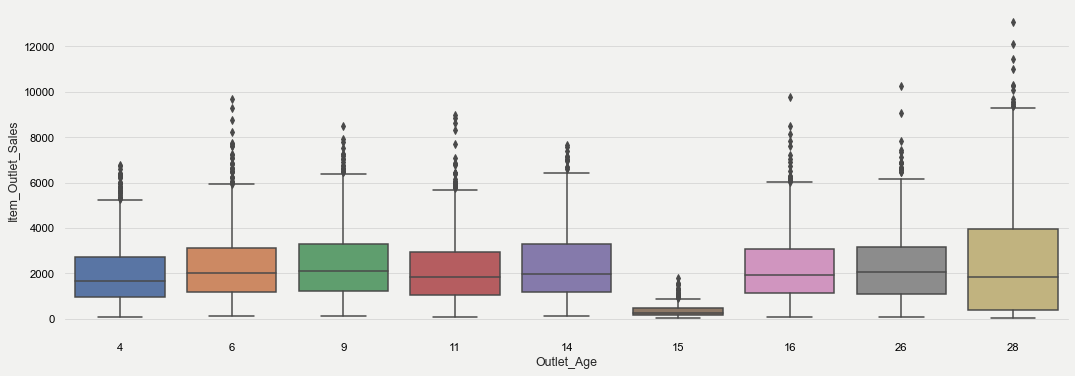

In [43]:
fig= plt.figure(figsize=(18, 6))
sns.boxplot(x='Outlet_Age', y='Item_Outlet_Sales', data=train_df);

The hypothesis that we had - **As the store gets older, the sales increases** does not seem to hold true based on the above plot. Because for different age of stores the sales have similar distribution approximately. But let's keep this variable as of now, and we will revisit this variable again the time of model building and we remove this variable by observing its significance later on.

## Modeling

Now that we have analyzed the all the variables in the dataset, we are now ready to start building the model. We have observed that not all the independent variables are important to predict the outcome variable. But at the beginning, we will use the all the variables and then from the model summary we will take decision which variable to remove from the model. Model building is an iterative task.

In [44]:
# we are removing the outcome variable from the feature set and also the variable Outlet_Establishment_Year as we have created
# a new variable Outlet_Age
train_features = train_df.drop(['Item_Outlet_Sales', 'Outlet_Establishment_Year'], axis=1)

# and then we are extracting the outcome variable separately
train_target = train_df['Item_Outlet_Sales']

In linear based models, whenever we have categorical variables as independent variables, we need to create **one hot encoded** representation (which is also known as dummy variables) of those categorical variables. The below piece of code is creating dummy variables and we are removing the first category in those variables which is known as **reference variable**. The reference variable helps to interpret the linear regression which we will see later.

In [45]:
train_df.head(3)

Item_Weight Item_Fat_Content  Item_Visibility    Item_Type  Item_MRP  \
0         9.30          Low Fat         0.016047        Dairy  249.8092   
1         5.92          Regular         0.019278  Soft Drinks   48.2692   
2        17.50          Low Fat         0.016760         Meat  141.6180   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   

         Outlet_Type  Item_Outlet_Sales  Outlet_Age  
0  Supermarket Type1          3735.1380          14  
1  Supermarket Type2           443.4228           4  
2  Supermarket Type1          2097.2700          14

In [46]:
# in linear based models it is mandatory to create dummy variables for the categorical variables
train_features = pd.get_dummies(train_features, drop_first=True)
train_features.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Age  \
0         9.30         0.016047  249.8092          14   
1         5.92         0.019278   48.2692           4   
2        17.50         0.016760  141.6180          14   
3        19.20         0.000000  182.0950          15   
4         8.93         0.000000   53.8614          26   

   Item_Fat_Content_Regular  Item_Type_Breads  Item_Type_Breakfast  \
0                         0                 0                    0   
1                         1                 0                    0   
2                         0                 0                    0   
3                         1                 0                    0   
4                         0                 0                    0   

   Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  ...  \
0                 0                1                       0  ...   
1                 0                0                       0  ...   
2                 0                0                       0  ...   
3                 0                0                       0  ...   
4                 0                0                       0  ...   

   Item_Type_Snack Foods  Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
0                      0                      0                        0   
1                      0                      1                        0   
2                      0                      0                        0   
3                      0                      0                        0   
4                      0                      0                        0   

   Outlet_Size_Medium  Outlet_Size_Small  Outlet_Location_Type_Tier 2  \
0                   1                  0                            0   
1                   1                  0                            0   
2                   1                  0                            0   
3                   0                  1                            0   
4                   0                  0                            0   

   Outlet_Location_Type_Tier 3  Outlet_Type_Supermarket Type1  \
0                            0                              1   
1                            1                              0   
2                            0                              1   
3                            1                              0   
4                            1                              1   

   Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  
0                              0                              0  
1                              1                              0  
2                              0                              0  
3                              0                              0  
4                              0                              0  

[5 rows x 27 columns]

#### Observations:

- Notice the column names of all the categorical variables, and also the overall number of columns has increased after we created the dummy variables
- And for each of those categorical variables, the first category have been removed, e.g. - the category `Low Fat` of the categorical variable `Item_Fat_Content` have been removed which became the `reference variable` and we only have the category `Regular` as a new column `Item_Fat_Content_Regular`

Below we are scaling the numerical variables in the dataset to have same range. If we don't do this, then the model will be biased towards a variable where we have a higher range and the model will not learn from the variables which values with lower range. There are many ways to do scaling, here we are using `MinMaxScaler` as we have both categorical and numerical variables in the dataset and we don't want to change the dummy encodings of the categorical variables that we have already created. For more information on different ways of doing scaling, refer to the **section 6.3.1** of this page [here](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)

In [47]:
# creating an instance of the MinMaxScaler
scaler = MinMaxScaler()

# applying fit_transform on the training features data
train_features_scaled = scaler.fit_transform(train_features)

# the above scaler returns the data in array format, below we are converting back to pandas dataframe
train_features_scaled = pd.DataFrame(train_features_scaled, index=train_features.index, columns=train_features.columns)
train_features_scaled.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Age  \
0     0.282525         0.048866  0.927507    0.416667   
1     0.081274         0.058705  0.072068    0.000000   
2     0.770765         0.051037  0.468288    0.416667   
3     0.871986         0.000000  0.640093    0.458333   
4     0.260494         0.000000  0.095805    0.916667   

   Item_Fat_Content_Regular  Item_Type_Breads  Item_Type_Breakfast  \
0                       0.0               0.0                  0.0   
1                       1.0               0.0                  0.0   
2                       0.0               0.0                  0.0   
3                       1.0               0.0                  0.0   
4                       0.0               0.0                  0.0   

   Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  ...  \
0               0.0              1.0                     0.0  ...   
1               0.0              0.0                     0.0  ...   
2               0.0              0.0                     0.0  ...   
3               0.0              0.0                     0.0  ...   
4               0.0              0.0                     0.0  ...   

   Item_Type_Snack Foods  Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
0                    0.0                    0.0                      0.0   
1                    0.0                    1.0                      0.0   
2                    0.0                    0.0                      0.0   
3                    0.0                    0.0                      0.0   
4                    0.0                    0.0                      0.0   

   Outlet_Size_Medium  Outlet_Size_Small  Outlet_Location_Type_Tier 2  \
0                 1.0                0.0                          0.0   
1                 1.0                0.0                          0.0   
2                 1.0                0.0                          0.0   
3                 0.0                1.0                          0.0   
4                 0.0                0.0                          0.0   

   Outlet_Location_Type_Tier 3  Outlet_Type_Supermarket Type1  \
0                          0.0                            1.0   
1                          1.0                            0.0   
2                          0.0                            1.0   
3                          1.0                            0.0   
4                          1.0                            1.0   

   Outlet_Type_Supermarket Type2  Outlet_Type_Supermarket Type3  
0                            0.0                            0.0  
1                            1.0                            0.0  
2                            0.0                            0.0  
3                            0.0                            0.0  
4                            0.0                            0.0  

[5 rows x 27 columns]

Now as the dataset is ready and prepared, we are set to build the model using `statsmodels` package

In [48]:
# here we are adding the intercept term
train_features_scaled = sm.add_constant(train_features_scaled)

# calling the OLS algorithm on the train features and target variable
ols_model_0 = sm.OLS(train_target, train_features_scaled)

# fitting the model
ols_res_0 = ols_model_0.fit()

Now let's observe summary of the model

In [49]:
ols_res_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     405.8
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:49:21   Log-Likelihood:                -71993.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8495   BIC:                         1.442e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             184.6913    508.427      0.363      0.716    -811.948    1181.331
Item_Weight                        -2.4232     48.658     -0.050      0.960     -97.804      92.958
Item_Visibility                   -99.3076     81.717     -1.215      0.224    -259.494      60.878
Item_MRP                         3668.6581     46.593     78.738      0.000    3577.324    3759.992
Outlet_Age                       -745.3059    250.312     -2.978      0.003   -1235.979    -254.633
Item_Fat_Content_Regular           40.3504     28.246      1.429      0.153     -15.018      95.719
Item_Type_Breads                    5.9310     84.086      0.071      0.944    -158.898     170.760
Item_Type_Breakfast                 7.0732    116.663      0.061      0.952    -221.615     235.761
Item_Type_Canned                   26.9165     62.798      0.429      0.668     -96.182     150.015
Item_Type_Dairy                   -40.7712     62.257     -0.655      0.513    -162.810      81.267
Item_Type_Frozen Foods            -27.7013     58.896     -0.470      0.638    -143.152      87.749
Item_Type_Fruits and Vegetables    29.2897     54.985      0.533      0.594     -78.494     137.073
Item_Type_Hard Drinks              -1.3641     90.230     -0.015      0.988    -178.238     175.510
Item_Type_Health and Hygiene      -11.9045     68.043     -0.175      0.861    -145.285     121.476
Item_Type_Household               -38.9278     59.948     -0.649      0.516    -156.440      78.585
Item_Type_Meat                      0.3923     70.683      0.006      0.996    -138.164     138.949
Item_Type_Others                  -23.0745     98.671     -0.234      0.815    -216.494     170.345
Item_Type_Seafood                 186.0226    148.082      1.256      0.209    -104.255     476.300
Item_Type_Snack Foods             -10.5839     55.275     -0.191      0.848    -118.937      97.769
Item_Type_Soft Drinks             -27.3167     70.207     -0.389      0.697    -164.939     110.305
Item_Type_Starchy Foods            22.7139    103.085      0.220      0.826    -179.358     224.786
Outlet_Size_Medium               -728.1791    274.680     -2.651      0.008   -1266.618    -189.740
Outlet_Size_Small                -762.7210    254.944     -2.992      0.003   -1262.473    -262.969
Outlet_Location_Type_Tier 2      -168.5810     87.638     -1.924      0.054    -340.373       3.211
Outlet_Location_Type_Tier 3      -421.6479    152.013     -2.774      0.006    -719.630    -123.665
Outlet_Type_Supermarket Type1    1515.9106    140.027     10.826      0.000    1241.423    1790.398
Outlet_Type_Supermarket Type2    1252.4485    123.874     10.111      0.000    1009.625    1495.272
Outlet_Type_Supermarket Type3    3724.5449    176.039     21.158      0.000    3379

In [50]:
ols_res_0.pvalues[ols_res_0.pvalues <= 0.05].index

Index(['Item_MRP', 'Outlet_Age', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype='object')

- We can see that `R-squared` for the model is `0.563`. 
- Not all the variables are statistically significant to predict the outcome variable. To check which are statistically significant or have predictive power to predict the target variable, we need to check the `p-value` against all the independent variables.

**Interpreting the Regression Results:**

1. **Adjusted. R-squared**: It reflects the fit of the model.
    - R-squared values range from 0 to 1, where a higher value generally indicates a better fit, assuming certain conditions are met.
    - In our case, the value for Adj. R-squared is **0.562**

2. **coeff**: It represents the change in the output Y due to a change of one unit in the variable (everything else held constant).
3. **std err**: It reflects the level of accuracy of the coefficients.
    - The lower it is, the more accurate the coefficients are.
4. **P >|t|**: It is p-value.
   
   * Pr(>|t|) : For each independent feature there is a null hypothesis and alternate hypothesis 

    Ho : Independent feature is not significant 
   
    Ha : Independent feature is that it is 
    
   * A p-value of less than 0.05 is considered to be statistically significant.

   
5. **Confidence Interval**: It represents the range in which our coefficients are likely to fall (with a likelihood of 95%).

To understand in detail, how p-values can help to identify statistically significant variables to predict the sales, we need to understand the hypothesis testing framework here - 

In the following example, we are showing the null hypothesis between the independent variable `Outlet_Size` and the dependent variable `Item_Outlet_Sales` to identify if there is any relationship between them or not.

- **Null hypothesis:** There is nothing going on or there is no relationship between variables `Outlet_Size` and `Item_Outlet_Sales` 

<center>$\mu_{\text {outlet size }=\text { High }}=\mu_{\text {outlet size }=\text { Medium }}=\mu_{\text {outlet size }=\text { Small }}$</center>

- **Alternate hypothesis:** There is something going on, because of which there is a relationship between variables `Outlet_Size` and `Item_Outlet_Sales` i.e. - 

<center>$\mu_{\text {outlet size = High }} \neq \mu_{\text {outlet size = Medium }} \neq \mu_{\text {outlet size }=\text { small }}$</center>

and from the above model summary if p-value less than the significance level 0.05, that means we will reject the null hypothesis in favor of alternate hypothesis. In other words, we have enough statistical evidence that there is relationship exists between the variables `Outlet_Size` and `Item_Outlet_Sales`

Based on this above analysis, if we observe the above model summary, we can see only some variables or some categories of a categorical variables have p-value lower than 0.05

### Feature Selection

As we have discussed above, that not all variables are statistically significant to predict the dependent/outcome variable. In this step, we are selecting only the relevant features `based on p-value` which we discussed above and eliminating all the other variables that are not important.

In [51]:
ols_res_0.pvalues[ols_res_0.pvalues <= 0.05]

Item_MRP                         0.000000e+00
Outlet_Age                       2.914253e-03
Outlet_Size_Medium               8.039954e-03
Outlet_Size_Small                2.782057e-03
Outlet_Location_Type_Tier 3      5.553335e-03
Outlet_Type_Supermarket Type1    3.903134e-27
Outlet_Type_Supermarket Type2    6.762448e-24
Outlet_Type_Supermarket Type3    7.194957e-97
dtype: float64

In [52]:
ols_res_0.pvalues[ols_res_0.pvalues <= 0.05].index

Index(['Item_MRP', 'Outlet_Age', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Supermarket Type1',
       'Outlet_Type_Supermarket Type2', 'Outlet_Type_Supermarket Type3'],
      dtype='object')

In [53]:
# selecting only relevant features
train_features_2 = train_df[['Item_MRP', 'Outlet_Age', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']]

Again we are creating the dummy variables for the categorical variables as we discussed above

In [54]:
train_features_2 = pd.get_dummies(train_features_2, drop_first=True)
train_features_2.head()

Item_MRP  Outlet_Age  Outlet_Size_Medium  Outlet_Size_Small  \
0  249.8092          14                   1                  0   
1   48.2692           4                   1                  0   
2  141.6180          14                   1                  0   
3  182.0950          15                   0                  1   
4   53.8614          26                   0                  0   

   Outlet_Location_Type_Tier 2  Outlet_Location_Type_Tier 3  \
0                            0                            0   
1                            0                            1   
2                            0                            0   
3                            0                            1   
4                            0                            1   

   Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
0                              1                              0   
1                              0                              1   
2                              1                              0   
3                              0                              0   
4                              1                              0   

   Outlet_Type_Supermarket Type3  
0                              0  
1                              0  
2                              0  
3                              0  
4                              0

Then we are scaling the variables to have the same scale

In [55]:
train_features_scaled_2 = scaler.fit_transform(train_features_2)
train_features_scaled_2 = pd.DataFrame(train_features_scaled_2, index=train_features_2.index, columns=train_features_2.columns)
train_features_scaled_2.head()

Item_MRP  Outlet_Age  Outlet_Size_Medium  Outlet_Size_Small  \
0  0.927507    0.416667                 1.0                0.0   
1  0.072068    0.000000                 1.0                0.0   
2  0.468288    0.416667                 1.0                0.0   
3  0.640093    0.458333                 0.0                1.0   
4  0.095805    0.916667                 0.0                0.0   

   Outlet_Location_Type_Tier 2  Outlet_Location_Type_Tier 3  \
0                          0.0                          0.0   
1                          0.0                          1.0   
2                          0.0                          0.0   
3                          0.0                          1.0   
4                          0.0                          1.0   

   Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
0                            1.0                            0.0   
1                            0.0                            1.0   
2                            1.0                            0.0   
3                            0.0                            0.0   
4                            1.0                            0.0   

   Outlet_Type_Supermarket Type3  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            0.0

And now build the model again, but this time with only taking the relevant variables based on p-values

In [56]:
train_features_scaled_2 = sm.add_constant(train_features_scaled_2)

ols_model_2 = sm.OLS(train_target, train_features_scaled_2)
ols_res_2 = ols_model_2.fit()

In [57]:
ols_res_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     1217.
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:49:21   Log-Likelihood:                -71998.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8513   BIC:                         1.441e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           139.5151    504.725      0.276      0.782    -849.868    1128.898
Item_MRP                       3667.9031     46.276     79.262      0.000    3577.192    3758.615
Outlet_Age                     -735.7980    250.035     -2.943      0.003   -1225.928    -245.668
Outlet_Size_Medium             -715.9299    274.383     -2.609      0.009   -1253.787    -178.073
Outlet_Size_Small              -752.5194    254.691     -2.955      0.003   -1251.776    -253.263
Outlet_Location_Type_Tier 2    -164.7302     87.524     -1.882      0.060    -336.299       6.839
Outlet_Location_Type_Tier 3    -414.9560    151.838     -2.733      0.006    -712.595    -117.317
Outlet_Type_Supermarket Type1  1534.2705    139.340     11.011      0.000    1261.130    1807.411
Outlet_Type_Supermarket Type2  1268.2890    123.308     10.286      0.000    1026.576    1510.002
Outlet_Type_Supermarket Type3  3731.8464    175.564     21.256      0.000    3387.699    4075.994
==============================================================================
Omnibus:                      960.769   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2289.231
Skew:                           0.667   Prob(JB):                         0.00
Kurtosis:                       5.160   Cond. No.                         95.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- The R-Squared value did not change at all. It is still coming out to be 0.563 which implies that all other variables were not adding any value to the model.

Lets' check assumptions of the linear regression model

### Checking for assumptions and rebuilding the model

In this step, we will check for the below assumptions in the model, to check if they hold true or not. And if there is any issue, then we will rebuild the model after fixing those issues

1. No multicollinearity among independent variables
2. Mean of residuals should be 0
3. Normality of error terms
4. Linearity of variables
5.  No heteroscedasticity

#### No multicollinearity among independent variables

* Multicollinearity occurs when predictor variables in a regression model are correlated. This correlation is a problem because predictor variables should be independent.  If the correlation between variables is high, it can cause problems when we fit the model and interpret the results. When we have multicollinearity in the linear model, the coefficients that the model suggests are unreliable.

* There are different ways of detecting (or testing) multi-collinearity, one such way is Variation Inflation Factor.

* **Variance  Inflation  factor**:  Variance  inflation  factors  measures  the  inflation  in  the variances of the regression parameter estimates due to collinearities that exist among the  predictors.  It  is  a  measure  of  how  much  the  variance  of  the  estimated  regression coefficient βk is “inflated” by  the  existence  of  correlation  among  the  predictor variables in the model. 

* General Rule of thumb: If VIF is 1 then there is no correlation among the kth predictor and the remaining predictor variables, and  hence  the variance of β̂k is not inflated at all. Whereas if VIF exceeds 5 or is close to exceeding 5, we say there is moderate VIF and if it is 10 or exceeding 10, it shows signs of high multi-collinearity.

In [58]:
# we drop the one with the highest vif value and check the Adjusted-R Squared
vif_series_1 = pd.Series([variance_inflation_factor(train_features_scaled_2.values,i) for i in range(train_features_scaled_2.shape[1])],
                          index=train_features_scaled_2.columns)

print('Series before feature selection: \n\n{}\n'.format(vif_series_1))

Series before feature selection: 

const                            1703.138903
Item_MRP                            1.000182
Outlet_Age                         50.851534
Outlet_Size_Medium                110.890861
Outlet_Size_Small                 106.701575
Outlet_Location_Type_Tier 2        11.266788
Outlet_Location_Type_Tier 3        36.770793
Outlet_Type_Supermarket Type1      29.359000
Outlet_Type_Supermarket Type2       9.863086
Outlet_Type_Supermarket Type3      20.126350
dtype: float64



#### Removing Multicollinearity
 * To remove multicollinearity, we will drop the column that has VIF score greater than 5 and build the model again.

We can see that the variable `Outlet_Size_Medium` has the highest VIF, so in the next iteration we will remove this variable and build the model again

In [59]:
train_features_scaled_3 = train_features_scaled_2.drop(['Outlet_Size_Medium'], axis=1)
ols_model_3 = sm.OLS(train_target, train_features_scaled_3)
ols_res_3 = ols_model_3.fit()

In [60]:
ols_res_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     1367.
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:49:21   Log-Likelihood:                -72002.
No. Observations:                8523   AIC:                         1.440e+05
Df Residuals:                    8514   BIC:                         1.441e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -1153.6485     95.520    -12.078      0.000   -1340.890    -966.407
Item_MRP                       3667.0969     46.290     79.219      0.000    3576.356    3757.837
Outlet_Age                     -116.5171     78.681     -1.481      0.139    -270.752      37.718
Outlet_Size_Small              -101.2256     50.634     -1.999      0.046    -200.481      -1.970
Outlet_Location_Type_Tier 2      24.4142     49.064      0.498      0.619     -71.764     120.592
Outlet_Location_Type_Tier 3     -34.7055     42.638     -0.814      0.416    -118.286      48.875
Outlet_Type_Supermarket Type1  1866.8788     56.288     33.167      0.000    1756.541    1977.217
Outlet_Type_Supermarket Type2  1465.6499     97.417     15.045      0.000    1274.690    1656.610
Outlet_Type_Supermarket Type3  3309.9199     68.391     48.397      0.000    3175.857    3443.983
==============================================================================
Omnibus:                      962.481   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2296.814
Skew:                           0.668   Prob(JB):                         0.00
Kurtosis:                       5.164   Cond. No.                         20.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, let's check the VIF again

In [61]:
vif_series_2 = pd.Series([variance_inflation_factor(train_features_scaled_3.values,i) for i in range(train_features_scaled_3.shape[1])],
                        index=train_features_scaled_3.columns)
print('Series before feature selection: \n\n{}\n'.format(vif_series_2))

Series before feature selection: 

const                            60.957867
Item_MRP                          1.000137
Outlet_Age                        5.032103
Outlet_Size_Small                 4.214391
Outlet_Location_Type_Tier 2       3.538163
Outlet_Location_Type_Tier 3       2.897614
Outlet_Type_Supermarket Type1     4.787661
Outlet_Type_Supermarket Type2     6.151776
Outlet_Type_Supermarket Type3     3.052102
dtype: float64



- VIF score for `Outlet_Type_Supermarket Type2` is the highest and more than 5. Let's remove this variable and build the model again.

In [62]:
train_features_scaled_4 = train_features_scaled_3.drop(['Outlet_Type_Supermarket Type2'], axis=1)
ols_model_4 = sm.OLS(train_target, train_features_scaled_4)
ols_res_4 = ols_model_4.fit()

In [63]:
ols_res_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     1491.
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:49:21   Log-Likelihood:                -72113.
No. Observations:                8523   AIC:                         1.442e+05
Df Residuals:                    8515   BIC:                         1.443e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.5034     57.571      0.026      0.979    -111.351     114.357
Item_MRP                       3672.0092     46.898     78.298      0.000    3580.078    3763.940
Outlet_Age                     -965.3974     55.560    -17.376      0.000   -1074.308    -856.486
Outlet_Size_Small              -512.6249     43.176    -11.873      0.000    -597.261    -427.989
Outlet_Location_Type_Tier 2     -22.9907     49.607     -0.463      0.643    -120.232      74.251
Outlet_Location_Type_Tier 3      61.1836     42.713      1.432      0.152     -22.545     144.912
Outlet_Type_Supermarket Type1  1333.4061     44.290     30.106      0.000    1246.586    1420.226
Outlet_Type_Supermarket Type3  2905.4968     63.714     45.602      0.000    2780.602    3030.391
==============================================================================
Omnibus:                      916.516   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2076.548
Skew:                           0.655   Prob(JB):                         0.00
Kurtosis:                       5.032   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
vif_series_3 = pd.Series([variance_inflation_factor(train_features_scaled_4.values,i) for i in range(train_features_scaled_4.shape[1])],
                        index=train_features_scaled_4.columns)
print('Series before feature selection: \n\n{}\n'.format(vif_series_3))

Series before feature selection: 

const                            21.573179
Item_MRP                          1.000087
Outlet_Age                        2.444472
Outlet_Size_Small                 2.985318
Outlet_Location_Type_Tier 2       3.523572
Outlet_Location_Type_Tier 3       2.832871
Outlet_Type_Supermarket Type1     2.887798
Outlet_Type_Supermarket Type3     2.580609
dtype: float64



- We have removed the multi-collinearity from the data as all the variables have VIF score less than 5 (except constant)
- But some of the variables in the model have become insignificant. Let's drop these variables.

In [65]:
train_features_scaled_5 = train_features_scaled_4.drop(['Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3'], axis=1)
ols_model_5 = sm.OLS(train_target, train_features_scaled_5)
ols_res_5 = ols_model_5.fit()

In [66]:
ols_res_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     2087.
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:49:21   Log-Likelihood:                -72114.
No. Observations:                8523   AIC:                         1.442e+05
Df Residuals:                    8517   BIC:                         1.443e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            59.1690     40.979      1.444      0.149     -21.161     139.499
Item_MRP                       3672.4152     46.897     78.307      0.000    3580.485    3764.345
Outlet_Age                     -941.5194     42.449    -22.180      0.000   -1024.730    -858.309
Outlet_Size_Small              -553.5221     27.615    -20.044      0.000    -607.655    -499.390
Outlet_Type_Supermarket Type1  1291.9098     29.987     43.082      0.000    1233.128    1350.692
Outlet_Type_Supermarket Type3  2884.9499     53.450     53.975      0.000    2780.175    2989.724
==============================================================================
Omnibus:                      918.244   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2083.648
Skew:                           0.656   Prob(JB):                         0.00
Kurtosis:                       5.036   Cond. No.                         7.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Save output as image

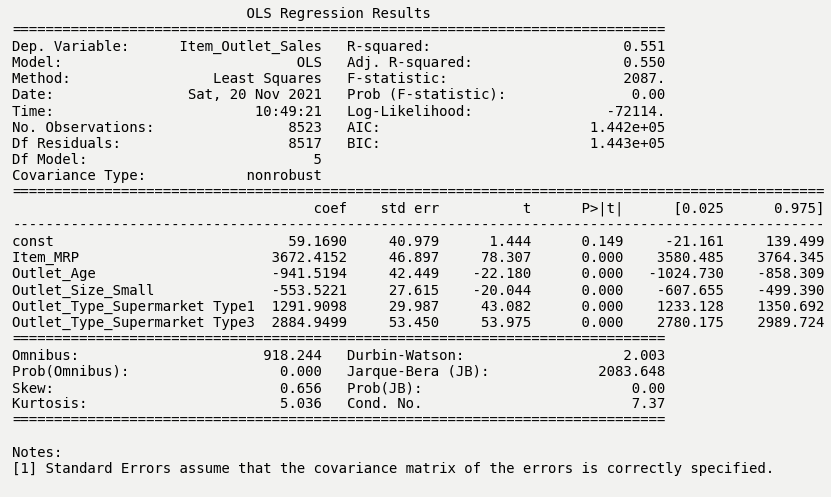

In [67]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(ols_res_5.summary()), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('multiple_regression_summary.png', bbox_inches='tight', dpi=90);

- All the variables are significant now and the R-Squared has not decreased by much. It is still coming out to be 0.55.

Let's check other assumptions

### Mean of residuals should be 0 and normality of error terms

In [68]:
residual = ols_res_5.resid # Residuals

In [69]:
residual.mean()

5.0195479983408486e-12

The mean of residuals is very close to 0. Hence, the corresponding assumption is satisfied.

### Test for Normality

**What is the test?**

* Error terms/Residuals should be normally distributed

* If the error terms are non- normally distributed, confidence intervals may become too wide or narrow. Once confidence interval becomes unstable, it leads to difficulty in estimating coefficients based on minimization of least squares.

**What do non-normality indicate?**

* It suggests that there are a few unusual data points which must be studied closely to make a better model.

**How to Check the Normality?**

* It can be checked via QQ Plot. Residuals following normal distribution will make a straight line plot otherwise not.

* Other test to check for normality : Shapiro-Wilk test.

**What is the residuals are not-normal?**

* We can apply transformations like log, exponential, arcsinh, etc as per our data

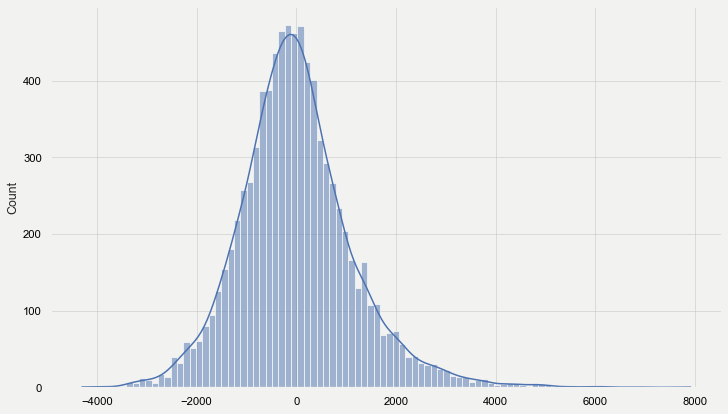

In [70]:
# Plot histogram of residuals
sns.histplot(residual, kde=True);

We can see that the error terms are normally distributed. The assumption of normality is satisfied.

### Linearity of variables

It states that the predictor variables must have a linear relation with the dependent variable.

To test the assumption, we'll plot residuals and fitted values on a plot and ensure that residuals do not form a strong pattern. They should be randomly and uniformly scattered on the x-axis.

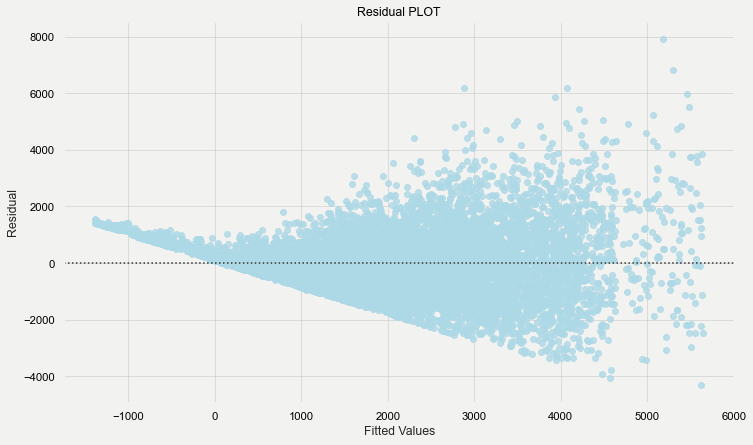

In [71]:
# predicted values
fitted = ols_res_5.fittedvalues

# sns.set_style("whitegrid")
sns.residplot(x = fitted, y = residual, color="lightblue")
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

- We can see that there is some pattern in fitted values and residuals i.e. the residuals are not randomly distributed.
- Let's try to fix this. We can apply the log transformation on the target variable and try to build a new model.

In [72]:
#Log transformation on the target variable
train_target_log = np.log(train_target)

In [73]:
#Fitting new model with the transformed target variable
ols_model_6 = sm.OLS(train_target_log, train_features_scaled_5)
ols_res_6 = ols_model_6.fit()

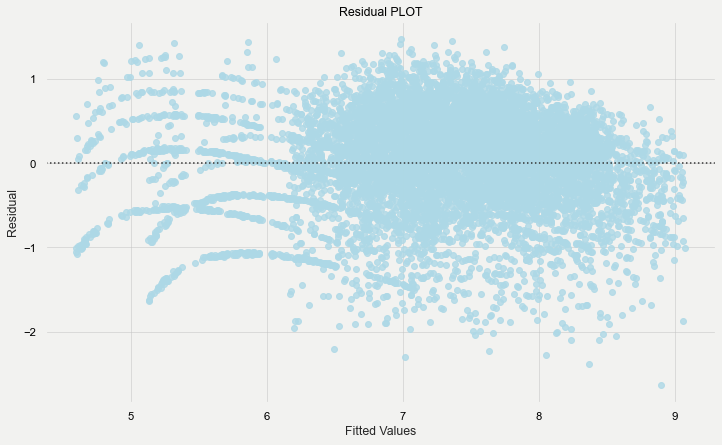

In [74]:
# predicted values
fitted = ols_res_6.fittedvalues
residual1 = ols_res_6.resid

# sns.set_style("whitegrid")
sns.residplot(x = fitted, y = residual1, color="lightblue")
plt.xlabel("Fitted Values")
plt.ylabel("Residual")
plt.title("Residual PLOT")
plt.show()

### Regression Outlier Detection 

**studentized residuals:**

- A studentized residual is simply a residual divided by its estimated standard deviation.

- In practice, we typically say that any observation in a dataset that has a studentized residual greater than an absolute value of 3 is an outlier.

- We can quickly obtain the studentized residuals of a regression model in Python by using the `OLSResults.outlier_test()` function from *statsmodels*.

In [75]:
stud_res = ols_res_6.outlier_test()
stud_res.tail()

student_resid   unadj_p  bonf(p)
8518      -0.104605  0.916691      1.0
8519      -1.453401  0.146149      1.0
8520       0.071039  0.943369      1.0
8521       1.314292  0.188783      1.0
8522      -0.049764  0.960311      1.0

This DataFrame displays the following values for each observation in the dataset:

- The studentized residual
- The unadjusted p-value of the studentized residual
- The Bonferroni-corrected p-value of the studentized residual

### Cook’s Distance

- Cook’s distance is used to identify influential observations in a regression model.

**Formula:**
$$ D_i = (r_{i}^2 / p \ast MSE) \ast (h_{ii} / ( 1 - h_{ii})^2) $$

**where:**

- $r_i$ is the ith residual
- $p$ is the number of coefficients in the regression model
- $MSE$ is the mean squared error
- $h_{ii}$ is the ith leverage value

- Essentially Cook’s distance measures how much all of the fitted values in the model change when the ith observation is deleted.

- The larger the value for Cook’s distance, the more influential a given observation.

A general rule of thumb is that any observation with a Cook’s distance greater than $4/n$ (where $n$ = total observations) is considered to be highly influential.

In [76]:
influence = ols_res_6.get_influence()

cooks = influence.cooks_distance[0]
stud_res['cooks'] = cooks

stud_res.tail()

student_resid   unadj_p  bonf(p)         cooks
8518      -0.104605  0.916691      1.0  1.631098e-06
8519      -1.453401  0.146149      1.0  1.009881e-04
8520       0.071039  0.943369      1.0  3.185032e-07
8521       1.314292  0.188783      1.0  2.769529e-04
8522      -0.049764  0.960311      1.0  1.628503e-07

In [77]:
# predicted values
fitted = ols_res_6.fittedvalues
residual1 = ols_res_6.resid

plt.figure(figsize=(15, 7))
sns.residplot(x = stud_res['cooks'].values, y = stud_res['student_resid'].values, color="lightblue")
plt.axhline(4, color='red', ls='--', lw=1.25)
plt.xlabel("Cook’s Distance")
plt.ylabel("Studentized Residuals")
plt.title("Residual PLOT")
plt.show()

#### Leverage

- Here Cook's Distance one the x-axis is considered Leverage

In contrast to an outlier, a leverage value has an unusual $x$ observation.  In other words, the observed value of a predictor is very unusual compared to other values. As a result, removing a leverage value from the dataset will have an impact on the OLS line. As a result, just a few observations with high leverage may result in questionable model fit. In multiple regression models we can’t just simply look at $x$ values within a variable and spot the leverage values because it is possible to have an observation within the normal range of each variable when the observation may be outside of the normal range when all regressors are considered simultaneously. Leverage statistic $h$ can be used to spot high leverage values where the cutoff is $(p + 1) / n$.  Any value above the h cutoff may be considered a leverage value. 

In [78]:
leverage = influence.hat_matrix_diag
stud_res['leverage'] = cooks

stud_res.tail()

student_resid   unadj_p  bonf(p)         cooks      leverage
8518      -0.104605  0.916691      1.0  1.631098e-06  1.631098e-06
8519      -1.453401  0.146149      1.0  1.009881e-04  1.009881e-04
8520       0.071039  0.943369      1.0  3.185032e-07  3.185032e-07
8521       1.314292  0.188783      1.0  2.769529e-04  2.769529e-04
8522      -0.049764  0.960311      1.0  1.628503e-07  1.628503e-07

In [79]:
stud_res.describe().T

count      mean       std           min       25%       50%  \
student_resid  8523.0 -0.000045  1.000206 -4.543748e+00 -0.602683  0.122785   
unadj_p        8523.0  0.510394  0.288432  5.602403e-06  0.273075  0.513701   
bonf(p)        8523.0  0.999731  0.013612  4.774928e-02  1.000000  1.000000   
cooks          8523.0  0.000119  0.000209  8.184248e-13  0.000009  0.000042   
leverage       8523.0  0.000119  0.000209  8.184248e-13  0.000009  0.000042   

                    75%       max  
student_resid  0.705705  2.538053  
unadj_p        0.763814  0.999913  
bonf(p)        1.000000  1.000000  
cooks          0.000134  0.003030  
leverage       0.000134  0.003030

In [80]:
outl_idx = stud_res[stud_res['student_resid'].abs() >= 4].index

train_df.iloc[outl_idx]

Item_Weight Item_Fat_Content  Item_Visibility              Item_Type  \
5048        5.785          Regular         0.038817  Fruits and Vegetables   
6726        9.300          Regular         0.014041            Snack Foods   

      Item_MRP  Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
5048  262.6252                       1999      Medium               Tier 1   
6726  199.1084                       1999      Medium               Tier 1   

            Outlet_Type  Item_Outlet_Sales  Outlet_Age  
5048  Supermarket Type1           524.6504          14  
6726  Supermarket Type1           396.8168          14

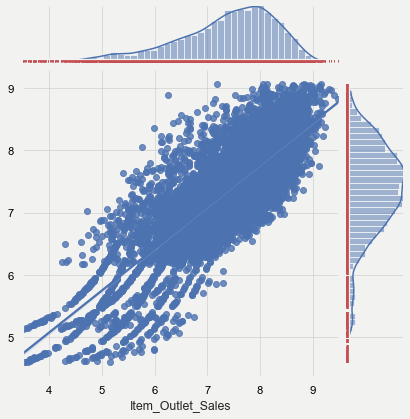

In [81]:
y_hat = ols_res_6.predict(train_features_scaled_5)

g = sns.jointplot(
    x=train_target_log,
    y=y_hat,
    kind='reg'
)
plt.ylabel('Predictions')
g.plot_marginals(sns.rugplot, color="r", height=-0.06, clip_on=False);

- We can see that there is no pattern in the residuals vs fitted values scatter plot now i.e. the linearity assumption is satisfied.
- Let's check the model summary of the latest model we have fit. 

In [82]:
ols_res_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     3540.
Date:                Sat, 20 Nov 2021   Prob (F-statistic):               0.00
Time:                        10:49:41   Log-Likelihood:                -7446.2
No. Observations:                8523   AIC:                         1.490e+04
Df Residuals:                    8517   BIC:                         1.495e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             6.1604      0.021    296.656      0.000       6.120       6.201
Item_MRP                          1.9623      0.024     82.572      0.000       1.916       2.009
Outlet_Age                       -1.0049      0.022    -46.717      0.000      -1.047      -0.963
Outlet_Size_Small                -0.5812      0.014    -41.530      0.000      -0.609      -0.554
Outlet_Type_Supermarket Type1     1.2249      0.015     80.605      0.000       1.195       1.255
Outlet_Type_Supermarket Type3     1.9662      0.027     72.594      0.000       1.913       2.019
==============================================================================
Omnibus:                      515.126   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              617.893
Skew:                          -0.620   Prob(JB):                    6.70e-135
Kurtosis:                       3.448   Cond. No.                         7.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
ols_res_6.params[1:].sort_values().plot(kind='barh');

- The model performance has improved significantly. The R-Squared has increased from 0.55 to 0.675.

Let's check the final assumption

### No heteroscedasticity

#### Test for homoscedasticity

* homoscedasticity - If the variance of the residuals are symmetrically distributed across the regression line, then the data is said to homoscedastic.

* heteroscedasticity - If the variance is unequal for the residuals across the regression line, then the data is said to be heteroscedastic. In this case the residuals can form an arrow shape or any other non symmetrical shape.

We will use Goldfeld–Quandt test to check homoscedasticity.

Null hypothesis : Residuals are homoscedastic

Alternate hypothesis : Residuals are hetroscedastic

In [84]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

In [85]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(train_target_log, train_features_scaled_5)
lzip(name, test)

[('F statistic', 0.9586092015528055), ('p-value', 0.9159984235118589)]

- As we can see from the above test the p-value is greater than 0.05, so we fail to reject the null-hypothesis. That means - residuals are homoscedastic.

We have verified all the assumptions of the linear regression model. The final equation of the model is as follows:

**$\log ($ Item_Outlet_Sales $)$ = 6.1604  $ + 1.9623 *$ Item_MRP - $1.0049 *$ Outlet_Age $ - 0.5812 *$ Outlet_Size_Small $+1.2249 *$ Outlet_Type_Supermarket Type1 $ + 1.9662 *$ Outlet_Type_Supermarket Type3**

Now we are finalized with the model, let's prepare the test dataset to predict the output

In [86]:
without_const=train_features_scaled_2.iloc[:,1:]
test_features = pd.get_dummies(test_df, drop_first=True)
test_features=test_features[list(without_const)]
test_features_scaled = scaler.transform(test_features)
test_features_scaled = pd.DataFrame(test_features_scaled, columns=without_const.columns)
test_features_scaled = sm.add_constant(test_features_scaled)
test_features_scaled.head()

const  Item_MRP  Outlet_Age  Outlet_Size_Medium  Outlet_Size_Small  \
0    1.0  0.325012    0.416667                 1.0                0.0   
1    1.0  0.237819    0.083333                 0.0                1.0   
2    1.0  0.893316    0.458333                 0.0                1.0   
3    1.0  0.525233    0.083333                 0.0                1.0   
4    1.0  0.861381    1.000000                 1.0                0.0   

   Outlet_Location_Type_Tier 2  Outlet_Location_Type_Tier 3  \
0                          0.0                          0.0   
1                          1.0                          0.0   
2                          0.0                          1.0   
3                          1.0                          0.0   
4                          0.0                          1.0   

   Outlet_Type_Supermarket Type1  Outlet_Type_Supermarket Type2  \
0                            1.0                            0.0   
1                            1.0                            0.0   
2                            0.0                            0.0   
3                            1.0                            0.0   
4                            0.0                            0.0   

   Outlet_Type_Supermarket Type3  
0                            0.0  
1                            0.0  
2                            0.0  
3                            0.0  
4                            1.0

In [87]:
test_features_scaled = test_features_scaled[train_features_scaled_5.columns]

### Evaluation Metric

#### R-squared

The R-squared metric gives us an indication that how good/bad our model is from a baseline model. Here, we have explained ~98% variance in the data as compared to the baseline model when there is no independent variable.

In [88]:
print(ols_res_6.rsquared)

0.6751411673487511


#### Mean Squared Error

This metric measures the average of the squares of the errors i.e. the average squared difference between the estimated values and the actual value.

In [89]:
print(ols_res_6.mse_resid)

0.3362667409042841


#### Root Mean Squared Error

This metric is same as the above but instead of square root of MSE to get RMSE

In [90]:
print(np.sqrt(ols_res_6.mse_resid))

0.5798851100901662


Below we are checking the cross validation score to identify if the model that we have built is `underfitted`, `overfitted` or `just right` model.

In [91]:
#Fitting linear model

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linearregression = LinearRegression(n_jobs=-1)                                    

cv_Score11 = cross_val_score(linearregression, train_features_scaled_5, train_target_log, cv = 10)
cv_Score12 = cross_val_score(linearregression, train_features_scaled_5, train_target_log, cv = 10, 
                             scoring = 'neg_mean_squared_error')                                  


print("RSquared: %0.3f (+/- %0.3f)" % (cv_Score11.mean(), cv_Score11.std() * 2))
print("Mean Squared Error: %0.3f (+/- %0.3f)" % (-1*cv_Score12.mean(), cv_Score12.std() * 2))

RSquared: 0.673 (+/- 0.058)
Mean Squared Error: 0.337 (+/- 0.030)


- The R-Squared on the cross validation is 0.673 which is almost similar to the R-Squared on the training dataset.
- And the MSE on cross validation is 0.337 which is almost similar to the R-Squared on the training dataset.

It seems like the out model is `just right`. It is giving a generalized performance.

Since this model that we have developed is a linear model, which is not capable of capturing non-linear patterns in the data, so we may want to build more advanced regression model which can capture the non-linearities in the data and improve this model further. But that is out of scope for this case study.

### Predicting on the test dataset

Once our model is completed, we can now use this to predict the sales in our test data as shown below:

In [92]:
# this test predictions will be on a log scale
test_predictions = ols_res_6.predict(test_features_scaled)

# we are converting the log scale predictions to its original scale
test_predictions_inverse_transformed = np.exp(test_predictions)

Point to remember: The output of this model is in log scale. So after prediction we need to transform this value in log back to its original scale by doing inverse of log transformation i.e. taking exponentiation</font>

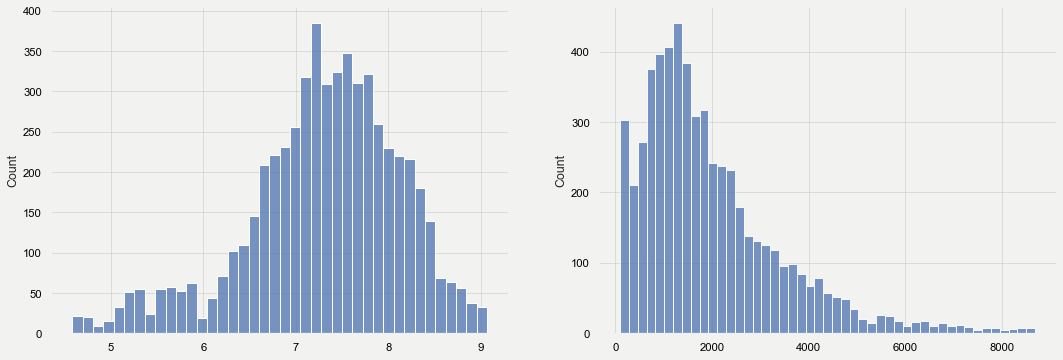

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.histplot(test_predictions, ax=ax[0]);
sns.histplot(test_predictions_inverse_transformed, ax=ax[1]);

### Conclusion and Recommendations

- We performed EDA - univariate and bivariate analysis on all the variables in the dataset
- We then performed missing values treatment using relationship between variables
- We started the model building the process with all the features
- We analyzed the model summary report
- Then we checked for different assumptions of linear regression
- And we then fixed the model iteratively if any assumptions did not hold true
- Then we evaluated the model using different evaluation metrics

Lastly below is the model equation:

**$\log ($ Item_Outlet_Sales $)$ = 6.1604  $ + 1.9623 *$ Item_MRP - $1.0049 *$ Outlet_Age $ - 0.5812 *$ Outlet_Size_Small $+1.2249 *$ Outlet_Type_Supermarket Type1 $ + 1.9662 *$ Outlet_Type_Supermarket Type3**

- From this above equation, we can interpret that - with one unit change in the variable `Item_MRP` the outcome variable log of `Item_Outlet_Sales` increases by 1.9623 units. So if we want to increase sales we may want to store higher MRP items in the high visibility area.

- On an average, the log sales of stores with outlet size small is 0.5812 less than the log sales of outlet size high (remember the **reference variable**, here for the variable outlet size - **the category high was the reference variable which we dropped at the time of creating the dummy variable**). So when we are interpreting the coefficients of categorical variables we need to compare them against its reference variable. So the recommendation to the management would be to focus more on the larger stores. May be they can focus on having more inventory in larger stores as compared to others as we don't want to loose on revenue because unavailability of items there.

- On an average, the log sales of stores with type Supermarket type 1 is 1.2249 more than the log sales of stores with type grocery stores (the **reference variable** for this categorical variable **Outlet_Type**, here is **grocery store**). And similarly for Supermarket Type 3, on an average, have 1.9662 times more log sales than grocery stores.

So after interpreting this linear regression equation it is clear that large stores of supermarket type 3 have more sales than others. So we want to maintain or improve the sales in these stores. And for the remaining ones we may want to make strategies to improve the sales e.g. providing better customer service, better training for store staffs, providing more visibility of high MRP item, etc.

## Model Interpretation 

In [94]:
from sklearn.metrics import r2_score, mean_squared_error 
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y, model, steps=1000, cmap=plt.cm.RdBu, mesh_step=0.25):
    """
    Function to plot the decision boundary and data points of a model.
    Data points are colored based on their actual label.
    """
    # Define region of interest by data limits
    xmin, xmax = X[:,0].min() - mesh_step, X[:,0].max() + mesh_step
    ymin, ymax = X[:,1].min() - mesh_step, X[:,1].max() + mesh_step
    steps = 1000
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)
    # Make predictions across region of interest
    labels = model.predict(np.c_[xx.ravel(), yy.ravel()])
    # Plot decision boundary in region of interest
    z = labels.reshape(xx.shape)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.7)
    # Get predicted labels on training data and plot
    train_labels = model.predict(X)
    ax.scatter(X[:,0], X[:,1], c=y.ravel(), cmap=cm_bright, lw=0.5, alpha=0.7, s=100, edgecolor='black')
    return fig, ax

In [95]:
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

Xtrain_PCA = PCA(n_components=2).fit_transform(train_features_scaled_5.values)
Xtest_PCA = PCA(n_components=2).fit_transform(test_features_scaled.values)
linearregression.fit(Xtrain_PCA, train_target_log.values)

fig, ax = plot_decision_boundary(
    Xtrain_PCA, 
    train_target_log.values, 
    linearregression, 
    cmap = plt.cm.RdBu, 
    mesh_step = 0.1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.margins(0.02, 0.02);

### Partial Dependance

![PDP.jpg](PDP.jpg)

In [96]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.inspection import partial_dependence, plot_partial_dependence

In [97]:
n1 = 1; n2 = 2

linearregression = LinearRegression(n_jobs=-1)                                    
linearregression.fit(train_features_scaled_5.values, train_target_log.values)

pdp0, axes0 = partial_dependence(
    linearregression, 
    train_features_scaled_5, 
    [train_features_scaled_5.columns[n1], train_features_scaled_5.columns[n2]], 
    grid_resolution=100
)
Z = pdp0[0].reshape(list(map(np.size, axes0))).T

In [98]:
pdp_surf = go.Contour(
        z=Z,
        x=axes0[0], 
        y=axes0[1],
        line_width=0.75,
        # colorscale='viridis',
        # line=dict(color='white'),
        contours=dict(
            #coloring ='heatmap',
            showlabels = True, # show labels on contours
            labelfont = dict( # label font properties
                size = 14,
                color = 'black',
            )))

layout = go.Layout(title='2D Partial dependence')

fig = go.Figure(data = [pdp_surf], layout=layout).update_layout(
         margin=dict(t=25, b=100, l=55, r=55, pad=0)
)\
        .update_xaxes(title_text=f'{train_features_scaled_5.columns[n1]}', title_font_size=16)\
        .update_yaxes(title_text=f'{train_features_scaled_5.columns[n2]}', title_font_size=16)

fig.show()

In [99]:
XX, YY = np.meshgrid(axes0[0], axes0[1])
X_train = train_features_scaled_5.iloc[:,1:]; y_train = train_target_log

In [100]:
col_1 = train_features_scaled_5.columns[n1]; col_2 = train_features_scaled_5.columns[n2]

df_ = pd.concat([
        train_features_scaled_5[[col_1, col_2]],
        y_train.to_frame('y')
    ], axis=1)

pca = PCA(n_components=2)

pca_df = pd.DataFrame(
    pca.fit_transform(train_features_scaled_5),
    index=train_features_scaled_5.index, 
    columns=['PC1', 'PC2']
)
pca_df['y'] = train_target_log.values

In [101]:
margin = 0.02
mesh_size = 0.01

x_min, x_max = pca_df.iloc[:,0].min() - margin, pca_df.iloc[:,0].max() + margin
y_min, y_max = pca_df.iloc[:,1].min() - margin, pca_df.iloc[:,1].max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

linearregression.fit(pca_df.iloc[:,:2], y_train)
pred = linearregression.predict(np.c_[xx.ravel(), yy.ravel()])
pred = pred.reshape(xx.shape)

fig = go.Figure(data=[go.Scatter3d(
    x=pca_df[pca_df.columns[0]], 
    y=pca_df[pca_df.columns[1]], 
    z=pca_df[pca_df.columns[2]], 
    mode='markers',
    marker=dict(
        size=12,
        color=np.where(y_train > y_train.mean(), 1, 0),                
        colorscale=[[0, "#FF0000"], [1, "#0000FF"]],   # choose a colorscale
        opacity=0.6
    ))])

fig.update_traces(marker=dict(size=5))
fig.add_traces(go.Surface(
    x=xrange, 
    y=yrange, 
    z=pred, 
    name='pred_surface',
    colorscale='RdBu'
)).update_layout(
    margin=dict(t=0, b=0, l=0, r=0, pad=0),
)
fig.show()

### [Shap Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

![SHAP1.jpg](SHAP1.jpg)

![SHAP2.jpg](SHAP2.jpg)

In [102]:
import shap

In [103]:
# load JS visualization code to notebook
shap.initjs()

linearregression.fit(X_train.values, y_train.values)

# explain the model's predictions using SHAP values
masker = shap.maskers.Independent(data=test_features_scaled.iloc[:,1:])

explainer = shap.Explainer(
    linearregression, 
    masker=masker, 
    data=X_train, 
    feature_names=X_train.columns, 
    algorithm='linear'
)

shap_values_ = explainer.shap_values(X_train.values)

#### Summary Plot

The scatter plot sorts features by their total SHAP values across all samples, and then shows how each feature impacts the model output as measured by the SHAP value as a function of the feature's value, represented by its color, where red represents high and blue represents low values relative to the feature's range.

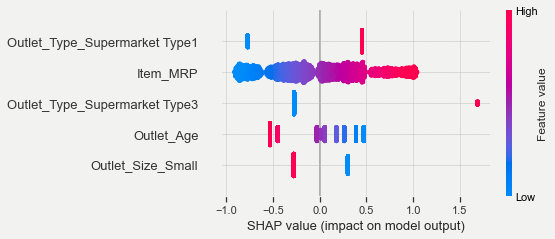

In [104]:
shap.summary_plot(shap_values_, X_train, show=False)
plt.tight_layout()

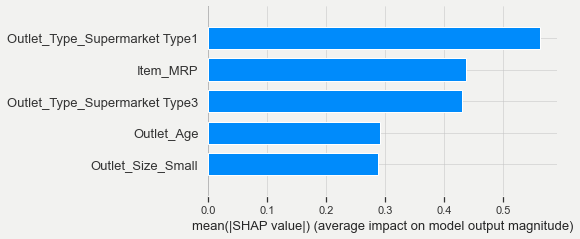

In [105]:
shap.summary_plot(shap_values_, X_train, plot_type="bar", show=False)
plt.tight_layout()

#### Force Plots
The following force plot shows the cumulative impact of various features and their values on the model output.

In [106]:
from random import shuffle, randint

i = randint(0, len(X_train))
args = (explainer.expected_value, shap_values_[i,:], X_train.iloc[i,:])

# visualize the first prediction's explanation
shap.force_plot(*args)

We can also compute force plots for numerous data points or predictions at a time and use a clustered visualization to gain insights into how prevalent certain influence patterns are across the dataset.

The following plot shows the force plots for the first $100$ observations rotated by 90 degrees, stacked horizontally, and ordered by the impact of different features on the outcome for the given observation.

The implementation uses hierarchical agglomerative clustering of data points on the feature SHAP values to identify these patterns, and displays the result interactively for exploratory analysis, as shown in the following code:

In [107]:
shap.force_plot(explainer.expected_value, shap_values_[:100,:], X_train.iloc[:100])

#### Interaction Plot

Lastly, SHAP values allow us to gain additional insights into the interaction effects between different features by separating these interactions from the main effects. The shap.dependence_plot can be defined as follows. It displays how different values for `Outlet_Age` (on the x axis) affect the outcome (SHAP value on the y axis), differentiated by `Item_MRP`:

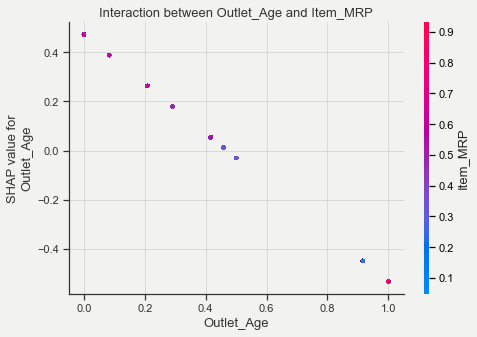

In [108]:
shap.dependence_plot("Outlet_Age", shap_values_, X_train, interaction_index=0, 
                     title='Interaction between Outlet_Age and Item_MRP')

SHAP values provide granular feature attribution at the level of each individual prediction, and enable much richer inspection of complex models through (interactive) visualization. The SHAP summary scatterplot displayed at the beginning of this section offers much more differentiated insights than a global feature-importance bar chart. Force plots of individual clustered predictions allow for more detailed analysis, while SHAP dependence plots capture interaction effects and, as a result, provide more accurate and detailed results than partial dependence plots.

The limitations of SHAP values, as with any current feature-importance measure, concern the attribution of the influence of variables that are highly correlated because their similar impact could be broken down in arbitrary ways.

### Heatmaps

We take a look at the full set of Shap contributions for the top $10$ mean absolute shap contribution features in our training set.

In [109]:
n = 10

top_shap_cols = pd.DataFrame(
    shap_values_, 
    columns=X_train.columns
).mean().sort_values(ascending=False).index[:n]

In [110]:
from sklearn.preprocessing import KBinsDiscretizer

y_pred_train = linearregression.predict(X_train)

test_shap_df = pd.DataFrame(np.column_stack((shap_values_, y_train.values, y_pred_train)),
                            index=X_train.index,
                            columns=list(X_train.columns) + ['y_true', 'y_pred'])

test_shap_df.sort_values('y_pred', inplace=True)

Discretizer = KBinsDiscretizer(n_bins=bin_count(y_pred_train), encode='ordinal', strategy='uniform')
test_shap_df = pd.DataFrame(
    Discretizer.fit_transform(test_shap_df.values),
    index=test_shap_df.index,
    columns=test_shap_df.columns
)

In [111]:
def double_heatmap(data1, data2, cbar_label1, cbar_label2,title='', subplot_top=0.86, 
                   cmap1='viridis', cmap2='viridis', grid_height_ratios=[1,4], figsize=(16,10)):
    """
    plot 2 seperate heatmaps one for the predictions and actual percentiles, 
    the other for the contributions
    """
    fig, (ax,ax2) = plt.subplots(nrows=2, figsize=figsize, 
                                 gridspec_kw={'height_ratios':grid_height_ratios})
    fig.suptitle(title)
    fig.subplots_adjust(hspace=0.02, top=subplot_top)
    # heatmap for actual and predicted percentiles
    g = sns.heatmap(data1, cmap=cmap1, ax=ax, xticklabels=False, 
                    cbar_kws={'location':'top', 
                              'use_gridspec':False, 
                              'pad':0.1,
                              'label': cbar_label1})
    g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=12) 
    ax.set_xlabel('')
    # heatmap of the feature contributions
    g2 = sns.heatmap(data2, ax=ax2, xticklabels=False, cmap=cmap2, 
                cbar_kws={'location':'bottom', 
                          'use_gridspec':False, 
                          'pad':0.07, 
                          'shrink':0.41,
                          'label': cbar_label2})
    g2.set_yticklabels(g2.get_yticklabels(), rotation=0, fontsize=12) 
    ax2.set_ylabel('');
    return fig

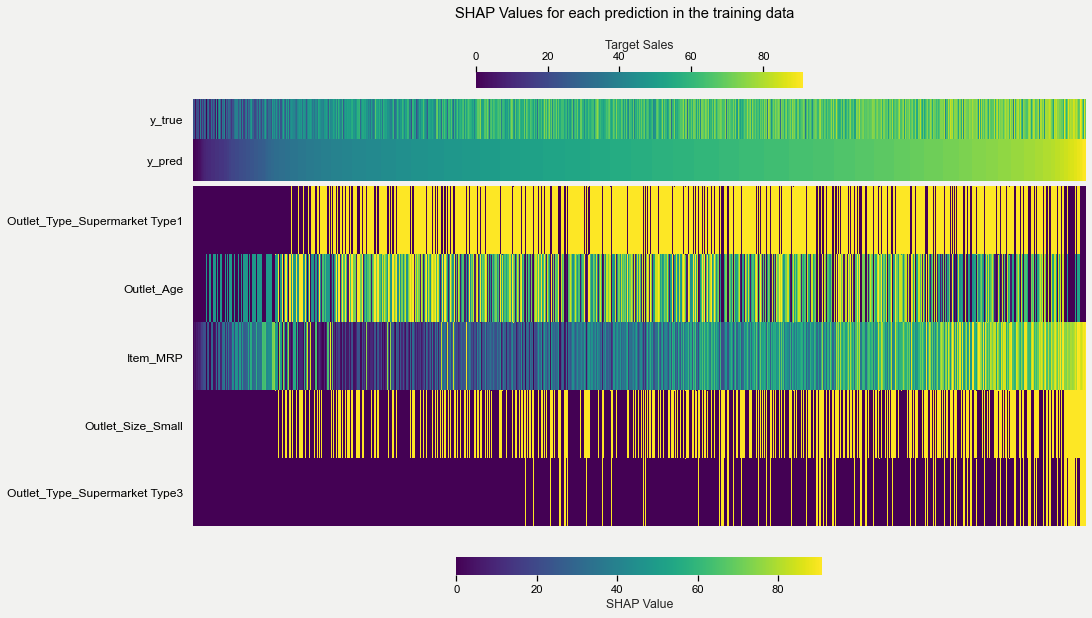

In [112]:
test_shap_df.sort_values('y_pred', inplace=True)

title = 'SHAP Values for each prediction in the training data'
fig = double_heatmap(test_shap_df[['y_true', 'y_pred']].T,
                     test_shap_df[top_shap_cols].T, 'Target Sales', 'SHAP Value',
                     title=title, subplot_top=0.89)

fig.axes[1].set_xlabel('');